### Spike Detection using Python

Tong-Wey performed manual spike analysis. Here we will try and use various Python packages to perform spike detection. He has set the amplifier's high pass filter at __10 Hz__ and low pass filter at __3 kHz.__

He has cited Tracey _et al._ 2003 as his methods, so I will attempt to apply below the data processing and analyses techniques in that paper.

_"Data were acquired at 10kHz with an Axo-patch 1-D amplifier and bandpass filtered at 100Hz–2kHz."_

The raw spikes were recorded in a .abf format on Clampex 10.4 by Molecular Devices. The files have be converted into a .atf format, which can be opened with Microsoft Excel. Some recordings were more noisy than others. Three of the files will be loaded here.

#### Initialize variables

In [1]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 10000.0 # sample rate
# Here we implement Tracey et al. 2003 bandpass settings.
lowcut = 100.0     # discard frequencies lower than this.
highcut = 2000.0   # discard frequencies higher than this.
order = 10         # order of the Butterworth filter (not exactly sure what this means, 
                   # but the higher the order, the "tighter" the cutoff.
    
# Define the datetimes and timedeltas here.
### WILL LIKELY HAVE TO CODE UP A WAY TO READ THIS FROM TONG-WEY'S PROTOCOL ###
import datetime 
starttime = datetime.datetime(2016, 7, 1, 0, 0, 3, 156100) 
# 0.1561 seconds = 156100 microseconds.
pulse = datetime.timedelta(milliseconds = 500)
pulseInterval = datetime.timedelta(seconds = 2)
    
# Print the current directory.
import os
os.getcwd()

'/Users/josesho/Google Drive/Data+Scripts/Python/optogenetics/optoElectro'

#### Load Libraries

In [2]:
!date
import seaborn as sb
import pandas as pd
import numpy as np
from numpy import fft
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator
import bootstrapContrast as bs
%matplotlib inline
sb.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none' # Ensures the text in figures are not lines but text.

def convert_time(a):
    import datetime
    sec = int(a) # get the second
    temp_us = round(a, 6) # round to 6 decimal places.
    us = str(a).split(".")[-1]
    mult = 6 - len(us)
    # extract the numbers after the decimal place. 
    # we need to add enough zeros so that we get
    # microseconds (1 millionth of a second).
    return datetime.datetime(2016, 7, 1, 0, 0, sec, int(us)*(10**mult))

Thu Sep 29 12:21:14 SGT 2016


#### Read in data and munge it
From Tong-Wey: 'The first pulse of green light starts at 3.1561 seconds. Each pulse is 500 ms long and separated by 2 seconds.' So we will read in the data, then pull out the 500ms before, during, and after illumination.

In [3]:
# Taken from 16719022_nSyb-Gal4.atf
acr = pd.read_csv('https://docs.google.com/spreadsheets/d/1mIzg1SoulkJSfJ5dj8G_2sh8_7fvGopnRMXqj4oiXYM/pub?gid=2020635131&single=true&output=csv',
                  index_col = 'Time_s', 
                  parse_dates=True, date_parser=convert_time)

control = pd.read_csv('https://docs.google.com/spreadsheets/d/14_WxvzkoCiDuCi_hOoymM2ckfNu-ctKbWwcyMEW9z1c/pub?gid=1817950117&single=true&output=csv',
                  index_col = 'Time_s', 
                  parse_dates=True, date_parser=convert_time)

#### Custom signal processing functions

In [4]:
# Bandpass filter.
# Taken from http://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    from scipy.signal import butter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    from scipy.signal import lfilter
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plotSpectrum(y, Fs, ax, figsize = (8,8)):
    """ Plots a Single-Sided Amplitude Spectrum of y(t)
    Modified from: http://glowingpython.blogspot.sg/2011/08/how-to-plot-frequency-spectrum-with.html """
    import numpy as np
    from numpy import fft
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[ np.arange( int(n/2) ) ] # one side frequency range

    Y = fft.fft(y)/n # fft computing and normalization
    Y = Y[ np.arange( int(n/2) ) ]

    ax.plot(frq, abs(Y),'r') # plotting the spectrum
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('|Y(freq)|')

def plotSpectrogram(y, Fs, ax, figsize = (8,8), colmap = 'plasma', ylim = (0,500)):
    """ Plots a Spectrogram of `y`, given the sampling frequency `fs`.
    Modified from: http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html """
    from scipy import signal
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)            # For more colormaps, see 
                                           # http://matplotlib.org/examples/color/colormaps_reference.html
    # (y,x,z) of spectrogram
    f, t, Sxx = signal.spectrogram(y, Fs)
    ax.pcolormesh(t, f, Sxx, cmap = cmap, axes = ax)
    ax.set_ylim(ylim)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

In [5]:
acr.head(10)

,Trace1_mV,Trace2_mV,Trace3_mV
Time_s,,,
2016-07-01 00:00:00.000000,0.000000,0.000000,0.000000
2016-07-01 00:00:00.000100,-0.006126,0.006158,-0.000108
2016-07-01 00:00:00.000200,-0.022363,0.023991,0.000363
2016-07-01 00:00:00.000300,-0.020829,0.024679,-0.000258
2016-07-01 00:00:00.000400,-0.018143,0.017919,-0.008138
2016-07-01 00:00:00.000500,-0.011511,0.016088,-0.006226
2016-07-01 00:00:00.000600,-0.005757,0.010761,0.000343
2016-07-01 00:00:00.000700,-0.004380,0.001500,-0.003246
2016-07-01 00:00:00.000800,-0.002510,-0.006227,-0.002295


67
0
7
221
7
8
163
0
19


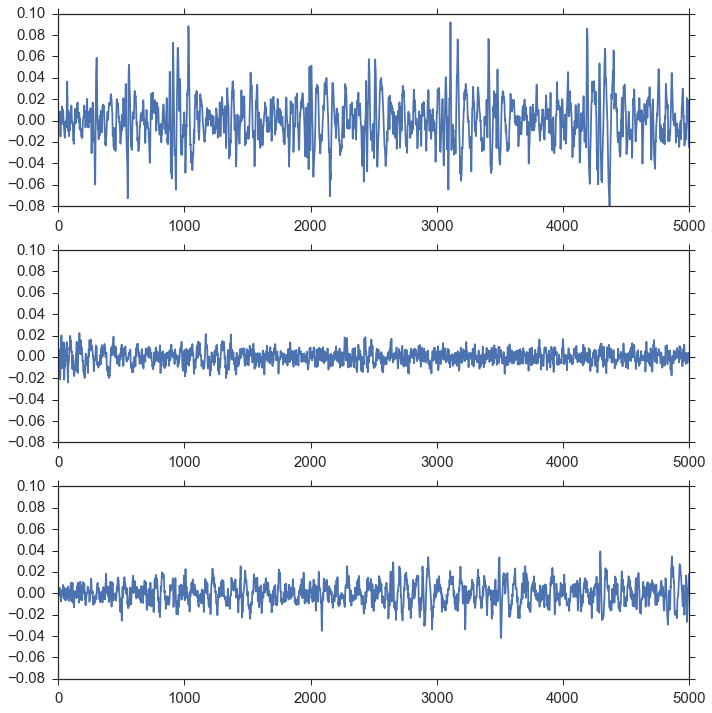

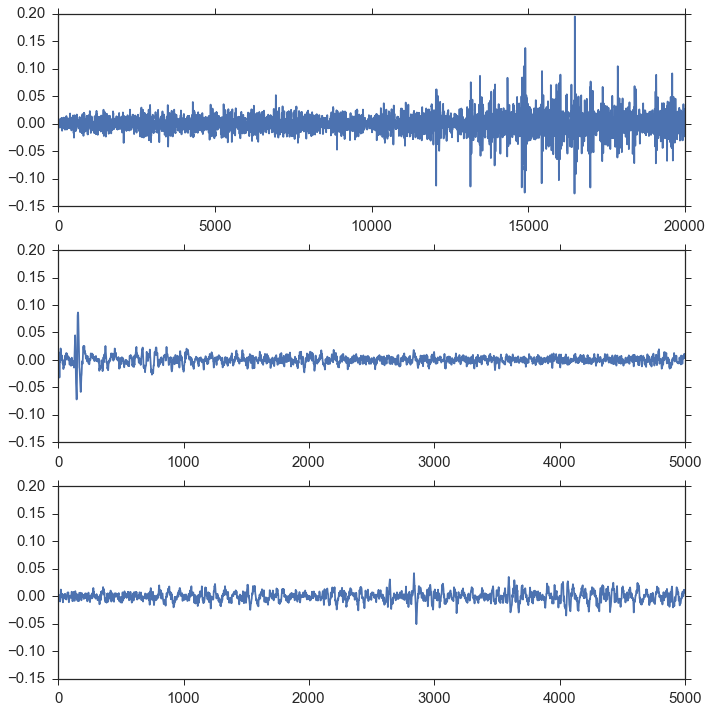

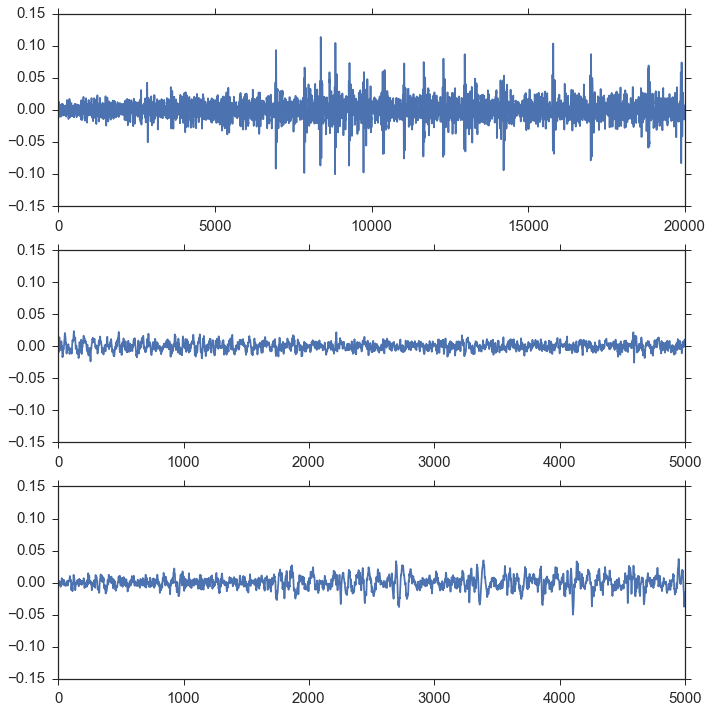

In [24]:
tracecol = 'Trace3_mV'

# Select before and after each onset of light for ACR larva, for Trace3 only.
acr_before_1 = acr.loc[starttime - pulse:starttime, tracecol]
acr_during_1 = acr.loc[starttime:starttime + pulse, tracecol]
acr_after_1 = acr.loc[starttime + pulse:starttime + pulse*2, tracecol]

acr_before_2 = acr.loc[starttime + pulse:starttime + pulse + pulseInterval, tracecol]
acr_during_2 = acr.loc[starttime + pulse + pulseInterval:starttime + pulse*2 + pulseInterval, tracecol]
acr_after_2 = acr.loc[starttime + pulse*2 + pulseInterval:starttime + pulse*3 + pulseInterval, tracecol]

acr_before_3 = acr.loc[starttime + pulse*2 + pulseInterval:starttime + pulse*2 + pulseInterval*2, tracecol]
acr_during_3 = acr.loc[starttime + pulse*2 + pulseInterval*2:starttime + pulse*3 + pulseInterval*2, tracecol]
acr_after_3 = acr.loc[starttime + pulse*3 + pulseInterval*2:starttime + pulse*4 + pulseInterval*2, tracecol]

# Bandpass filter the trace(s) of interest.
traces = [(acr_before_1, acr_during_1, acr_after_1),
         (acr_before_2, acr_during_2, acr_after_2),
         (acr_before_3, acr_during_3, acr_after_3)]

for num, traceSet in enumerate(traces):
#     before = np.array(traceSet[0])
#     during = np.array(traceSet[1])
#     after = np.array(traceSet[2])
    
    before = butter_bandpass_filter(traceSet[0], lowcut, highcut, fs, order)
    during = butter_bandpass_filter(traceSet[1], lowcut, highcut, fs, order)
    after = butter_bandpass_filter(traceSet[2], lowcut, highcut, fs, order)

    fig, axarr = plt.subplots(3, sharey = True, figsize = (10,10))
    import quickspikes as qs
    for i, bp in enumerate([before, during, after]):
        pd.Series(bp).plot( ax = axarr[i] )
        plt.tight_layout()

        d = qs.detector(1.5,500)
        d.scale_thresh(acr[acr.columns[num]].mean(), acr[acr.columns[num]].std())
        spikes_idx = d.send(bp)
        print(len(spikes_idx))